In [1]:
import ee
import os
import geehydro
import folium
import numpy as np
import pandas as pd
##import pandas as pd
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:10809'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:10809'
ee.Initialize()

In [3]:
Countrys = ["China","United Kingdom"]
yDic = [34,29,24,14,1]
df = pd.read_excel("centers.xls")
df1 = df.loc[df["SOV0NAME"].isin(Countrys)][["NAMEASCII","wof_id"]]
name_dic = {}
for i in range(len(df1)):
    city = df1.iloc[i,]["NAMEASCII"]
    fid = df1.iloc[i,]["wof_id"]
    name_dic[city] = fid

In [14]:
for name,fid in name_dic.items():
    print(name,type(fid))

Greenock <class 'numpy.int64'>
Sunderland <class 'numpy.int64'>
Southampton <class 'numpy.int64'>
Bristol <class 'numpy.int64'>
Bournemouth <class 'numpy.int64'>
Omagh <class 'numpy.int64'>
Chester <class 'numpy.int64'>
Swansea <class 'numpy.int64'>
Carlisle <class 'numpy.int64'>
Southend-on-Sea <class 'numpy.int64'>
Reading <class 'numpy.int64'>
Leicester <class 'numpy.int64'>
Bradford <class 'numpy.int64'>
Sheffield <class 'numpy.int64'>
Yumen <class 'numpy.int64'>
Linxia <class 'numpy.int64'>
Zhuozhou <class 'numpy.int64'>
Sanming <class 'numpy.int64'>
Huizhou <class 'numpy.int64'>
Chaozhou <class 'numpy.int64'>
Gyangze <class 'numpy.int64'>
Dali <class 'numpy.int64'>
Yangquan <class 'numpy.int64'>
Shiyan <class 'numpy.int64'>
Danjiangkou <class 'numpy.int64'>
Shashi <class 'numpy.int64'>
Anlu <class 'numpy.int64'>
Zixing <class 'numpy.int64'>
Deyang <class 'numpy.int64'>
Tengchong <class 'numpy.int64'>
Mengzi <class 'numpy.int64'>
Chuxiong <class 'numpy.int64'>
Hengshui <class 'num

In [5]:
name='Greenock'
fid = 101750635
center = ee.FeatureCollection("users/zhouzz400/Boundries/city_center").filter(ee.Filter.eq("wof_id",fid)).geometry()

In [9]:
center.getInfo()["coordinates"]

[-4.750030642576902, 55.93329145153005]

In [23]:
year_dic = {34:1985,33:1986,32:1987,31:1988,
            30:1989,29:1990,28:1991,27:1992,26:1993,25:1994,24:1995,23:1996,22:1997,21:1998,
            20:1999,19:2000,18:2001,17:2002,16:2003,15:2004,14:2005,13:2006,12:2007,11:2008,
            10:2009, 9:2010, 8:2011, 7:2012, 6:2013, 5:2014, 4:2015, 3:2016, 2:2017, 1:2018,} 
# greater than or equal  1 = urban 2018

In [24]:
np.round(30,0)

30

In [25]:
def getBandName(center):
    coor = center.getInfo()["coordinates"]
    print("coordinate: ",coor)
    BandLat = np.ceil(coor[1])
    left = "users/zhouzz400/GAIA_2018_lat/GAIA_1985_2018_"
    if BandLat>0:
        Bandname = left+"%02d"% BandLat
        ceilBandname = left+"%02d"% (BandLat+1)
        floorBandname = left+"%02d"% (BandLat-1)
    elif BandLat<-1:
        Bandname = left+"%03d"% BandLat
        ceilBandname = left+"%03d"% (BandLat+1)
        floorBandname = left+"%03d"% (BandLat-1)
    elif BandLat==0:
        Bandname = left+"%02d"% BandLat
        ceilBandname = left+"%02d"% (BandLat+1)
        floorBandname = left+"%03d"% (BandLat-1)
    elif BandLat==-1:
        Bandname = left+"%03d"% BandLat
        ceilBandname = left+"%02d"% (BandLat+1)
        floorBandname = left+"%03d"% (BandLat-1)
    print( Bandname,ceilBandname,floorBandname)
    return Bandname,ceilBandname,floorBandname

In [26]:
def getDensity(center,years=[34,24,14,4],maxdis=30,kdens = 0.1):
    Bandname,ceilBandname,floorBandname = getBandName(center)
    
    GAIA = ee.ImageCollection([Bandname,ceilBandname,floorBandname]).mosaic()
    #Viz_GAIA = {"min": 1, "max": 34, "palette": ['FFFFFF', 'FF0000']}
    # Map.addLayer(GAIA,Viz_GAIA)
    
    df= pd.DataFrame(columns = ["year","dis","ring_area","water_area","urban_area","dens"])
    for year in years:
        print("year begin: "+str(year_dic[year]))
        
        GAIA_year = GAIA.gte(year)
        #Viz_year = {"min": 0, "max": 1, "palette": ['FFFFFF', 'FF0000']}
        #Map.addLayer(sh_year,Viz_year,"sh_year")

        water = ee.Image("JRC/GSW1_1/YearlyHistory/"+str(year_dic[year])).gte(2)
        # Viz_water = {"min": 0, "max": 1, "palette": ["ffffff","0000ff"]}
        # Map.addLayer(water,Viz_water,"water")

        # center = ee.Geometry.Point([121.46851393726786, 31.224416065753665])
        buffer = []
        ring = []
        for i in range(maxdis):
            dis = 1000*(i+1)
            buffer.append( center.buffer(dis) )
            if i == 0:
                ring.append(buffer[i])

            else:
                ring.append( buffer[i].symmetricDifference(buffer[i-1]) )

            #Map.addLayer(ring[i])
            ring_urban = GAIA_year.eq(1).clip(ring[i])
            urban_image = ring_urban.multiply(ee.Image.pixelArea())
            urban_area = ee.Number( urban_image.reduceRegion(**{"reducer": ee.Reducer.sum(),"scale": 30,"maxPixels": 1e9}).get("b1") )

            ring_water = water.eq(1).clip(ring[i])
            water_image = ring_water.multiply(ee.Image.pixelArea())
            water_area = ee.Number( water_image.reduceRegion(**{"reducer": ee.Reducer.sum(),"scale": 30,"maxPixels": 1e9}).get("waterClass") )

            ring_area = ring[i].area()
            #print(ring_area.getInfo(),water_area.getInfo(),urban_area.getInfo())
           
            Denominator = ring_area.subtract( water_area )
            dens = urban_area.divide(Denominator).getInfo()
            #print(i,dens)
            
            dic = {"year":str(year_dic[year]),"dis":dis,"ring_area":ring_area.getInfo(),"water_area":water_area.getInfo(),
                   "urban_area":urban_area.getInfo(),"dens":dens}
            df = df.append(dic,ignore_index=True)
            
            if dens<=kdens:
                print("less than "+str(kdens)+" in:"+str(i))
                break
    return  df

In [27]:
centerNames = ["Wuhan"]
for centerName in centerNames:
    yDic = [34,29,24,19,14,9,4,1]

    center = ee.FeatureCollection("users/zhouzz400/Boundries/city_center").filter(ee.Filter.eq("NAME",centerName)).geometry()
    ## center = ee.Geometry.Point([121.46851393726786, 31.224416065753665])
    df = getDensity(center, years=yDic, maxdis=30, kdens=0.1)

    fname = "dens_"+centerName+".csv"
    df.to_csv(fname)

coordinate:  [114.26807190730287, 30.58197760967736]
users/zhouzz400/GAIA_2018_lat/GAIA_1985_2018_31 users/zhouzz400/GAIA_2018_lat/GAIA_1985_2018_32 users/zhouzz400/GAIA_2018_lat/GAIA_1985_2018_30
year begin: 1985
less than 0.1 in:0
year begin: 1990
less than 0.1 in:14
year begin: 1995
less than 0.1 in:18
year begin: 2000
less than 0.1 in:19
year begin: 2005
less than 0.1 in:21
year begin: 2010
less than 0.1 in:27
year begin: 2015
year begin: 2018


In [ ]:
demo = ee.List([1]).add(2)
print(demo)

In [ ]:

from ee_plugin import Map
import ee
import os
import numpy as np
import pandas as pd
##import pandas as pd
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:10809'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:10809'
ee.Initialize()

year_dic = {34:1985,33:1986,32:1987,31:1988,
            30:1989,29:1990,28:1991,27:1992,26:1993,25:1994,24:1995,23:1996,22:1997,21:1998,
            20:1999,19:2000,18:2001,17:2002,16:2003,15:2004,14:2005,13:2006,12:2007,11:2008,
            10:2009, 9:2010, 8:2011, 7:2012, 6:2013, 5:2014, 4:2015, 3:2016, 2:2017, 1:2018,} 

def getBandName(center):
    coor = center.getInfo()["coordinates"]
    print("coordinate: ",coor)
    BandLat = np.round(coor[1],0)
    left = "users/zhouzz400/GAIA_2018_lat/GAIA_1985_2018_"
    if BandLat>0:
        Bandname = left+"%02d"% BandLat
        ceilBandname = left+"%02d"% (BandLat+1)
        floorBandname = left+"%02d"% (BandLat-1)
    elif BandLat<-1:
        Bandname = left+"%03d"% BandLat
        ceilBandname = left+"%03d"% (BandLat+1)
        floorBandname = left+"%03d"% (BandLat-1)
    elif BandLat==0:
        Bandname = left+"%02d"% BandLat
        ceilBandname = left+"%02d"% (BandLat+1)
        floorBandname = left+"%03d"% (BandLat-1)
    elif BandLat==-1:
        Bandname = left+"%03d"% BandLat
        ceilBandname = left+"%02d"% (BandLat+1)
        floorBandname = left+"%03d"% (BandLat-1)
    return Bandname,ceilBandname,floorBandname            
            
def getDensity(center,years=[34,24,14,4],maxdis=30,kdens = 0.1):
    Bandname,ceilBandname,floorBandname = getBandName(center)
    
    GAIA = ee.ImageCollection([Bandname,ceilBandname,floorBandname]).mosaic()
    #Viz_GAIA = {"min": 1, "max": 34, "palette": ['FFFFFF', 'FF0000']}
    # Map.addLayer(GAIA,Viz_GAIA)
    
    df= pd.DataFrame(columns = ["year","dis","ring_area","water_area","urban_area","dens"])
    for year in years:
        print("year begin: "+str(year_dic[year]))
        
        GAIA_year = GAIA.gte(year)
        #Viz_year = {"min": 0, "max": 1, "palette": ['FFFFFF', 'FF0000']}
        #Map.addLayer(sh_year,Viz_year,"sh_year")

        water = ee.Image("JRC/GSW1_1/YearlyHistory/"+str(year_dic[year])).gte(2)
        # Viz_water = {"min": 0, "max": 1, "palette": ["ffffff","0000ff"]}
        # Map.addLayer(water,Viz_water,"water")

        # center = ee.Geometry.Point([121.46851393726786, 31.224416065753665])
        buffer = []
        ring = []

        for i in range(maxdis):
            dis = 1000*(i+1)
            buffer.append( center.buffer(dis) )
            if i == 0:
                ring.append(buffer[i])

            else:
                ring.append( buffer[i].symmetricDifference(buffer[i-1]) )

            Map.addLayer(ring[i])
            gaia_ring = GAIA.clip(ring[i])
            Map.addLayer(gaia_ring)
            
            ring_urban = GAIA_year.eq(1).clip(ring[i])
            urban_image = ring_urban.multiply(ee.Image.pixelArea())
            urban_area = ee.Number( urban_image.reduceRegion(**{"reducer": ee.Reducer.sum(),"scale": 30,"maxPixels": 1e9}).get("b1") )

            ring_water = water.eq(1).clip(ring[i])
            water_image = ring_water.multiply(ee.Image.pixelArea())
            water_area = ee.Number( water_image.reduceRegion(**{"reducer": ee.Reducer.sum(),"scale": 30,"maxPixels": 1e9}).get("waterClass") )

            ring_area = ring[i].area()
            #print(ring_area.getInfo(),water_area.getInfo(),urban_area.getInfo())
           
            Denominator = ring_area.subtract( water_area )
            dens = urban_area.divide(Denominator).getInfo()
            #print(i,dens)
            
            dic = {"year":str(year_dic[year]),"dis":dis,"ring_area":ring_area.getInfo(),"water_area":water_area.getInfo(),
                   "urban_area":urban_area.getInfo(),"dens":dens}
            df = df.append(dic,ignore_index=True)
            
            if dens<=kdens:
                print("less than "+str(kdens)+" in:"+str(i))
                break
    return  df

centerNames = ["Wuhan"]
for centerName in centerNames:
    yDic = [34,24,14,4]

    center = ee.FeatureCollection("users/zhouzz400/Boundries/city_center").filter(ee.Filter.eq("NAME",centerName)).geometry()
    ## center = ee.Geometry.Point([121.46851393726786, 31.224416065753665])
    df = getDensity(center, years=yDic, maxdis=30, kdens=0.4)

    fname = "dens_"+centerName+".csv"
            

## water merge

## calculate dens

In [53]:
Map = folium.Map(location=[40, -100], zoom_start=4)
Map.setOptions('HYBRID')

In [56]:
shanghai = ee.Image("users/zhouzz400/demo/shanghai_GAIA")
#Viz_GAIA = {"min": 1, "max": 34, "palette": ['FFFFFF', 'FF0000']}
# Map.addLayer(shanghai,Viz_GAIA)

sh_year = shanghai.gte(year)
#Viz_year = {"min": 0, "max": 1, "palette": ['FFFFFF', 'FF0000']}
#Map.addLayer(sh_year,Viz_year,"sh_year")

water = ee.Image("JRC/GSW1_1/YearlyHistory/"+str(year_dic[year])).gte(2)
# Viz_water = {"min": 0, "max": 1, "palette": ["ffffff","0000ff"]}
# Map.addLayer(water,Viz_water,"water")

# center = ee.Geometry.Point([121.46851393726786, 31.224416065753665])
buffer = []
ring = []
dens = []
for i in range(30):
    if i == 0:
        dis = 1000*(i+1)
        buffer.append(center.buffer(dis))
        ring.append(buffer[i])

    else:
        dis = 1000*(i+1)
        buffer.append( center.buffer(dis) )
        ring.append( buffer[i].symmetricDifference(buffer[i-1]) )
        
    Map.addLayer(ring[i])
    ring_urban = sh_year.eq(1).clip(ring[i])
    urban_image = ring_urban.multiply(ee.Image.pixelArea())
    urban_area = ee.Number( urban_image.reduceRegion(**{"reducer": ee.Reducer.sum(),"scale": 30,"maxPixels": 1e9}).get("b1") )
    
    ring_water = water.eq(1).clip(ring[i])
    water_image = ring_water.multiply(ee.Image.pixelArea())
    water_area = ee.Number( water_image.reduceRegion(**{"reducer": ee.Reducer.sum(),"scale": 30,"maxPixels": 1e9}).get("waterClass") )
    
    ring_area = ring[i].area()
    
    print(ring_area.getInfo(),water_area.getInfo(),urban_area.getInfo())
    Denominator = ring_area.subtract( water_area )
    dens.append( urban_area.divide(Denominator).getInfo() )
    print(i,dens[i])
    if dens[i]<=0.1:
        print("less than 0.1")
        break

3104060.629227633 3069.0177612304688 2648596.4865129064
0 0.8541127543587366
9312181.820185283 5030.92533605239 8375936.106401996
1 0.8999463102115827
15520302.808602128 138660.65986495675 14435798.395566951
2 0.9385082721321876
21728423.459531903 351126.6485957126 19818361.395891946
3 0.9270751850043676
27936543.637848005 1010802.8999049766 23859791.203039296
4 0.886133140597938
34144663.20868991 2047134.2731361522 26906342.618360333
5 0.838268349952533
40352782.036867924 2914515.973677569 28444644.039544553
6 0.75977461113007
46560899.987563245 1549375.523291494 29356225.807394836
7 0.652193547248029
52769016.925565265 1082948.4176858342 28977344.212995216
8 0.5606412917356576
58977132.71605217 1377007.066185326 30300490.651562475
9 0.5260490373883849
65185247.22380925 1224179.324823357 29096408.105465885
10 0.4549081036517092
71393360.31407043 1324055.7060723994 25242786.368363198
11 0.36025455810620205
77601471.85153332 1394317.553293984 21736457.089305438
12 0.28522856271786584
83

In [57]:
df = pd.DataFrame(dens)
name = "dens_"+centerName +"_"+str(year)+".csv"
df.to_csv(name)

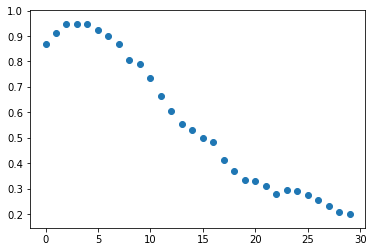

In [40]:
import matplotlib.pyplot as plt
plt.scatter([i for i in range(len(dens))],dens)

In [41]:
Map.centerObject(center,10)
Map.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map